## Phosphonetwork graph

This notebook provides an analysis of the Phosphonetwork triples graph.

In [15]:
# IMPORTANT
# make sure you have networkx 2.2 installed
# if not install and restart kernel
# !pip install networkx==2.2

import networkx as nx
print(nx.__version__)

2.2


In [16]:
import os
import pandas as pd
import numpy as np
import operator
import scipy
import matplotlib.pyplot as plt
from random import random

# setup file paths
fp_tomoe_data = os.environ['TOMOE_DATA_HOME']
fp_data_external = os.path.join(fp_tomoe_data, 'data-external/')
fp_data_kinases = os.path.join(fp_tomoe_data, 'data-wp-tomoe-kinases/')
fp_data_results = os.path.join(fp_data_kinases, 'results/RESULTS-FINAL-SAMPLE.csv')
fp_phosphonetwork = os.path.join(fp_data_kinases, 'interim/phosphonetwork/phosphonetwork_pps_1.0.tsv')

In [17]:
# Dataframes

# Phosphonetwork DF
df = pd.read_csv(fp_phosphonetwork, delimiter='\t')
print(df.head())

# RESULTS DF
df_results = pd.read_csv(fp_data_results, delimiter='\t')
df_results = df_results[['ProteinKinase_ID', 'ProteinSubstrate_ID', 'Score']]
df_results = df_results.head(10)
# print(df_results.head())

   kinase  site substrate
0  P15531  H118    P15531
1  P22392  H118    P22392
2  P22392  H358    O15554
3  O14757   S10    O95707
4  O14920   S10    Q9BXH1


### Original directed Phosphonetwork multigraph

In [18]:
# create a MultiDiGraph and get some intital stats

G = nx.from_pandas_edgelist(df, source='kinase', target='substrate', edge_attr='site', 
                            create_using=nx.MultiDiGraph())

print(nx.info(G))
print('G.is_directed: {}'.format(G.is_directed()))
print('G.is_multigraph: {}'.format(G.is_multigraph()))

#TODO check for self loops?

Name: 
Type: MultiDiGraph
Number of nodes: 2475
Number of edges: 10173
Average in degree:   4.1103
Average out degree:   4.1103
G.is_directed: True
G.is_multigraph: True


In [34]:
# Connectivity of original graph

# check if strongly and/or weakly connected
print('is_strongly_connected(G): {}'.format(nx.is_strongly_connected(G)))
print('is_weakly_connected(G): {}'.format(nx.is_weakly_connected(G)))

# get the size of the largest strongly connected component
largest_scc = max(nx.strongly_connected_components(G), key=len)

size_largest_scc = len(largest_scc)
print('size of the largest strongly connected component: {} nodes'.format(size_largest_scc))
print('size of original graph: {} nodes'.format(G.number_of_nodes()))

is_strongly_connected(G): False
is_weakly_connected(G): False
size of the largest strongly connected component: 106 nodes
size of original graph: 2475 nodes


#### Convert to undirected graph

In [64]:
# convert to undirected graph

G_und = nx.Graph(G)
largest_cc = max(nx.connected_components(G_und), key=len)
size_largest_cc = len(largest_cc)
print(nx.info(G_und))
print('is_connected(G_und): {}'.format(nx.is_connected(G_und)))
print('number of connected components G_und: {} nodes'.format(nx.number_connected_components(G_und)))
print('size of the largest connected component G_und: {} nodes'.format(size_largest_cc))

Name: 
Type: Graph
Number of nodes: 2475
Number of edges: 5508
Average degree:   4.4509
is_connected(G_und): False
number of connected components G_und: 34 nodes
size of the largest connected component G_und: 2430 nodes


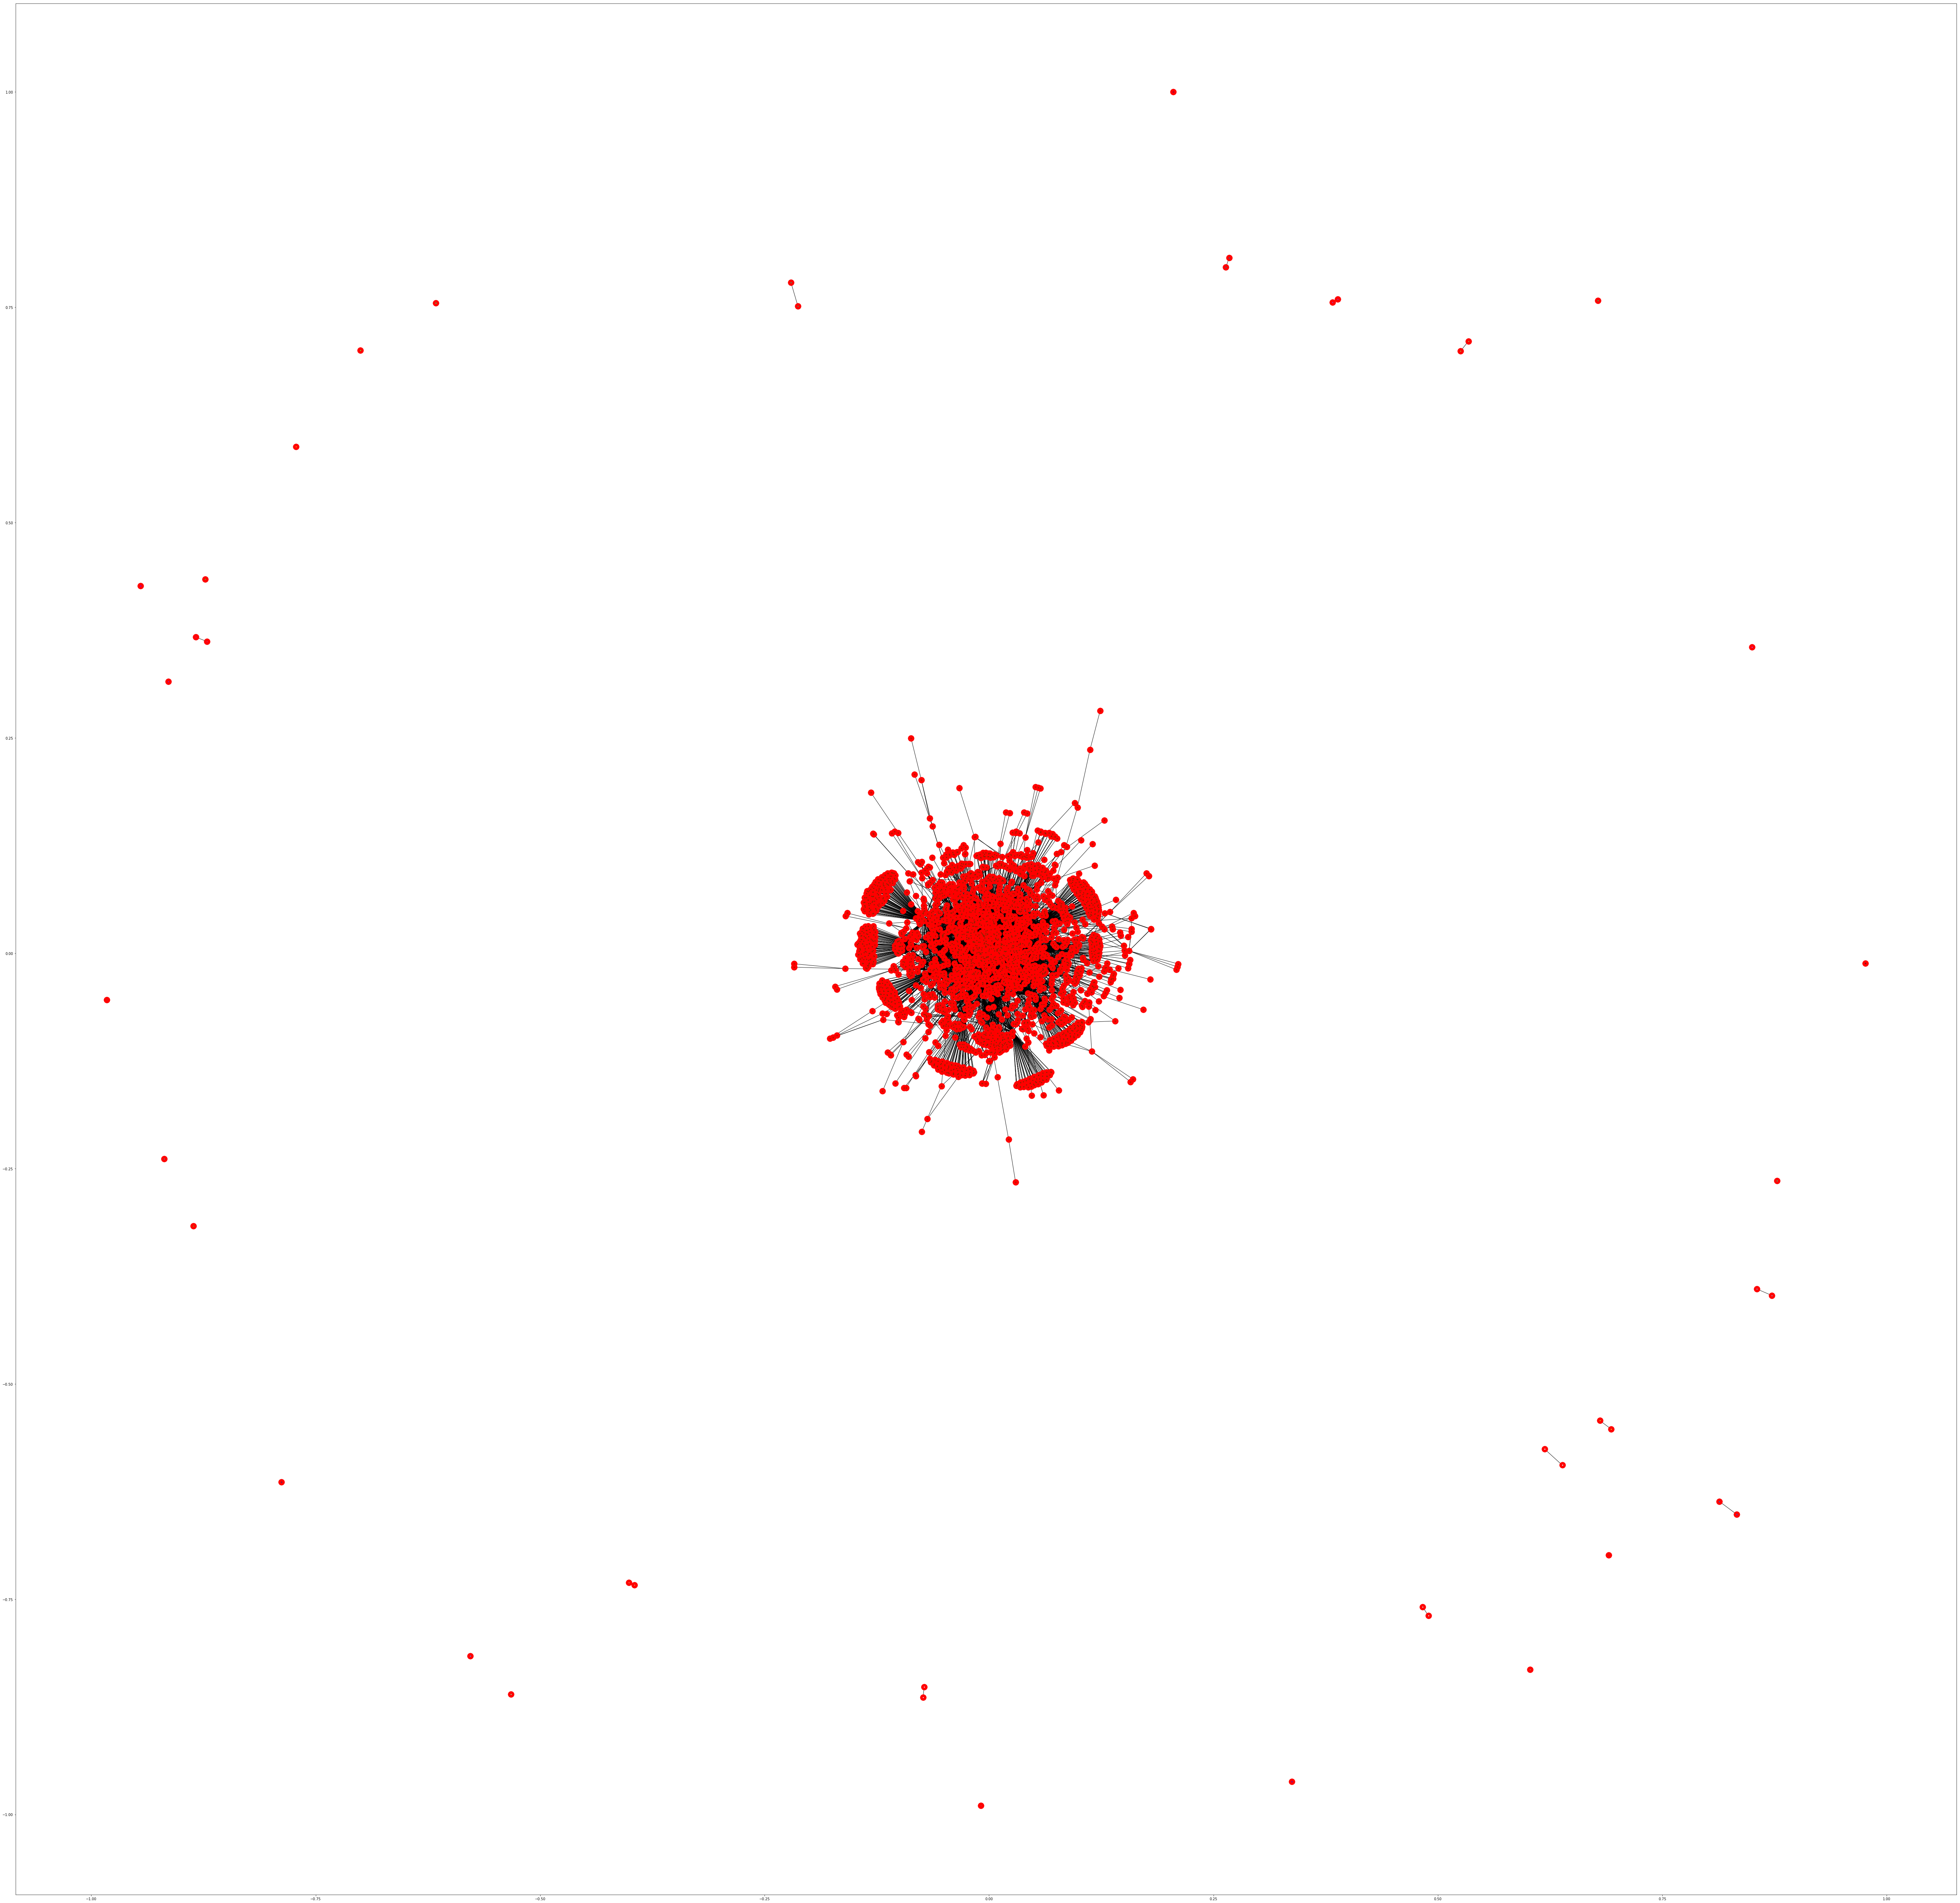

In [57]:
# draw G_und connected component subgraphs

ccs = (G.subgraph(c) for c in nx.connected_component_subgraphs(G_und)) # there are 34 connected components
pos = nx.spring_layout(G_und)
for cc in ccs:
    color = [(random(), random(), random()) for _i in range(1)]
    res = cc.nodes()
    k = G_und.subgraph(res)
    nx.draw_networkx(k, pos=pos , with_labels=False)#, node_color=color)
    nx.draw_networkx_nodes(k,pos=pos,
                       nodelist=res,
                       node_color=color,
                       node_size=5)
    
plt.rcParams['figure.figsize'] = [100, 100]
plt.show()

In [36]:
# Clustering and in-degree distribution of undirected subgraph

# Clustering
# global clustering: Avg local clustering coefficients
print('nx.average_clustering(G_und): {}'.format(nx.average_clustering(G_und)))
# global clustering: Transitivity
# print('nx.transitivity(G_und): {}'.format(nx.transitivity(G_und)))

nx.average_clustering(G_und): 0.06807677371200858


In [37]:
# Average shortest path length
# cannot compute, grpah must be connected

# print('nx.average_shortest_path_length(G_und): {}'.format(nx.average_shortest_path_length(G_und)))

In [38]:
# Degree Distribution
degrees = G_und.degree()
degree_values = sorted(set(d for n, d in degrees))

# get probability distribution as p(k) tuples

# dd = [(i, list(d for n, d in in_degrees).count(i)/float(nx.number_of_nodes(G)))
#              for i in degree_values]
# dd.sort(key=operator.itemgetter(0), reverse=True)
# print(dd)

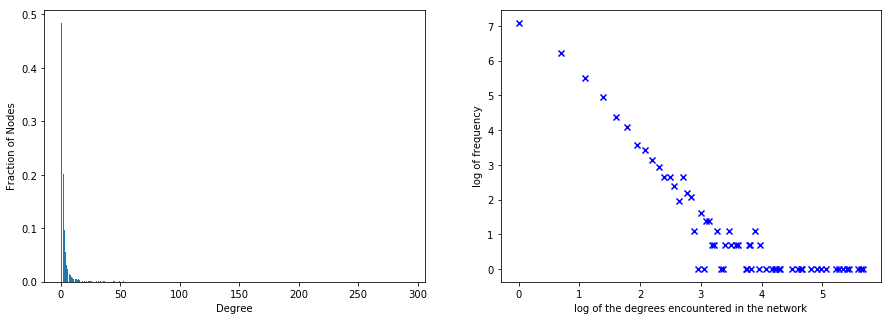

In [39]:
# plot degree distribution

# setup for plotting two graphs side by side
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

# GRAPH 1
histogram = [list(d for n, d in degrees).count(i)/float(nx.number_of_nodes(G_und))
             for i in degree_values]
ax1.bar(degree_values, histogram)
ax1.set_xlabel('Degree')
ax1.set_ylabel('Fraction of Nodes')
# plt.show()


# GRAPH 2 log-log degree distribution
"""
x axis -> the log of the degrees encountered in the network; 
y axis -> the log of the frequency of those degrees
"""
degree_freq = np.array(nx.degree_histogram(G_und))
"""A list of frequencies of degrees. The degree values are the index in the list."""

# subset of degree vlaues with non-zero freq.
degree_vals = np.where(degree_freq != 0)[0]
degree_vals_log = np.log(degree_vals)

# subset of non-zero degree freqs.
degree_freq = degree_freq[degree_vals]
degree_freq_log = np.log(degree_freq)

ax2.scatter(x = degree_vals_log,
            y = degree_freq_log, 
            c='b', marker='x')
ax2.set_xlabel('log of the degrees encountered in the network')
ax2.set_ylabel('log of frequency')

plt.show()

In [40]:
# cannot compuite below metrics, graph must be connected

# Diameter
# maximum distance between any pair of nodes
# print('maximum distance between any pair of nodes in G_und: {}'.format(nx.diameter(G_und)))

# Radius
# the radius is the minimum eccentricity
# i.e. the smallest of the largest distances between any pair of nodes
# # maximum distance between any pair of nodes
# print('radius of G_und (i.e. minimum eccentricity): {}'.format(nx.radius(G_und)))

# Periphery
# the periphery of a graph is the of set of nodes that have eccentricity equal to diameter
# i.e. the set of nodes that have a value of largest distance between them and all other nodes 
# print('periphery nodes of G_sc: {}'.format(nx.periphery(G_sc)))

# center nodes
# print('center nodes of G_sc: {}'.format(nx.center(G_sc)))

In [41]:
# a closer look at simple paths

# simple paths in G
print('\nsimple paths in G')
for row in df_results.itertuples():
    #print('...', row)
    kinase_id = row.ProteinKinase_ID
    substrate_id = row.ProteinSubstrate_ID
    #residue_id = row.Site
    model_score = row.Score

    try:
      all_simple_paths = list(nx.all_simple_paths(G, kinase_id, substrate_id, cutoff=3))
    except:
      continue
      
    if len(all_simple_paths)>0:
      """
      remove empty lists i.e. no simple paths exist 
      TODO do such cases need attention? > probably happens becuase G is not connected
      """
      path_lengths = [len(path) for path in all_simple_paths]
      print('{} {} number of simple paths in G: {} ; Average simple path length: {}'.format(
            kinase_id, 
            substrate_id, 
            len(all_simple_paths), 
            scipy.mean(path_lengths)))

      
# simple paths in G_und
print('\nsimple paths in G_und')
for row in df_results.itertuples():
    #print('...', row)
    kinase_id = row.ProteinKinase_ID
    substrate_id = row.ProteinSubstrate_ID
    #residue_id = row.Site
    model_score = row.Score
    
    try:
      all_simple_paths = list(nx.all_simple_paths(G_und, kinase_id, substrate_id, cutoff=3))
    except:
      continue
      
    path_lengths = [len(path) for path in all_simple_paths]
    print('{} {} number of simple paths in G_und: {} ; Average simple path length: {}'.format(
          kinase_id, 
          substrate_id, 
          len(all_simple_paths), 
          scipy.mean(path_lengths)))


simple paths in G
O60674 P46108 number of simple paths in G: 3 ; Average simple path length: 3.0
P51812 Q14315 number of simple paths in G: 1 ; Average simple path length: 4.0
P17252 O75376 number of simple paths in G: 13 ; Average simple path length: 3.6923076923076925
P07948 P43403 number of simple paths in G: 9 ; Average simple path length: 3.0
P06493 Q9UFC0 number of simple paths in G: 20 ; Average simple path length: 4.0

simple paths in G_und
O60674 P46108 number of simple paths in G_und: 2 ; Average simple path length: 3.5
P51812 Q14315 number of simple paths in G_und: 10 ; Average simple path length: 4.0
P51812 Q9H0H5 number of simple paths in G_und: 4 ; Average simple path length: 4.0
P33981 O14965 number of simple paths in G_und: 26 ; Average simple path length: 4.0
P06239 Q969T9 number of simple paths in G_und: 18 ; Average simple path length: 4.0
P17252 O75376 number of simple paths in G_und: 94 ; Average simple path length: 3.9680851063829787
P07948 P43403 number of simpl

In [42]:
# Top 5 by Betweenness Centrality (approximated)
"""
Assumption: important nodes connect other nodes.
Between Centrality asks: "What are the nodes that show up in the various shortest paths between u and v?"
"""
btwnCent_approx = nx.betweenness_centrality(G_und,
                                            normalized=True, 
                                            endpoints=False,
                                            k=100) # approximation param
sorted(btwnCent_approx.items(), key=operator.itemgetter(1), reverse=True)[0:5]

[('P06493', 0.16426471001084847),
 ('P24941', 0.1524357488247631),
 ('P17612', 0.1468731277768602),
 ('P68400', 0.12985151098962003),
 ('O14757', 0.1274362484976837)]

In [43]:
# pagerank
"""not implemented for multigraph type"""

print('G_und is_directed: {}'.format(G_und.is_directed()))
print('G_und is_multigraph: {}'.format(G_und.is_multigraph()))

pr = nx.pagerank(G_und)
print('top 5 pagerank nodes:\n')
sorted(pr.items(), key=operator.itemgetter(1), reverse=True)[0:5]

G_und is_directed: False
G_und is_multigraph: False
top 5 pagerank nodes:



[('P24941', 0.026974266279819064),
 ('P17612', 0.025915503885414196),
 ('P06493', 0.02288634594591833),
 ('P68400', 0.021541870372883645),
 ('P12931', 0.019417935101789754)]

In [44]:
# Hyperlink-Induced Topic Search (HITS) algorithm

h,a=nx.hits(G_und, max_iter=300)
print('authorities:\n', [i[0] for i in sorted(a.items(), key=operator.itemgetter(1), reverse=True)[0:5]])
print('\nhubs:\n', [i[0] for i in sorted(h.items(), key=operator.itemgetter(1), reverse=True)[0:5]])

authorities:
 ['P06493', 'P17612', 'P28482', 'P24941', 'P27361']

hubs:
 ['P06493', 'P17612', 'P28482', 'P24941', 'P27361']
